In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# !pip uninstall opencv-python -y
# # downgrade OpenCV a bit since some none-free features are not avilable
# !pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [0]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import plotly
from skimage import io
from skimage import morphology as morp
import plotly.express as px
import plotly.graph_objects as go
import math
import os
import glob

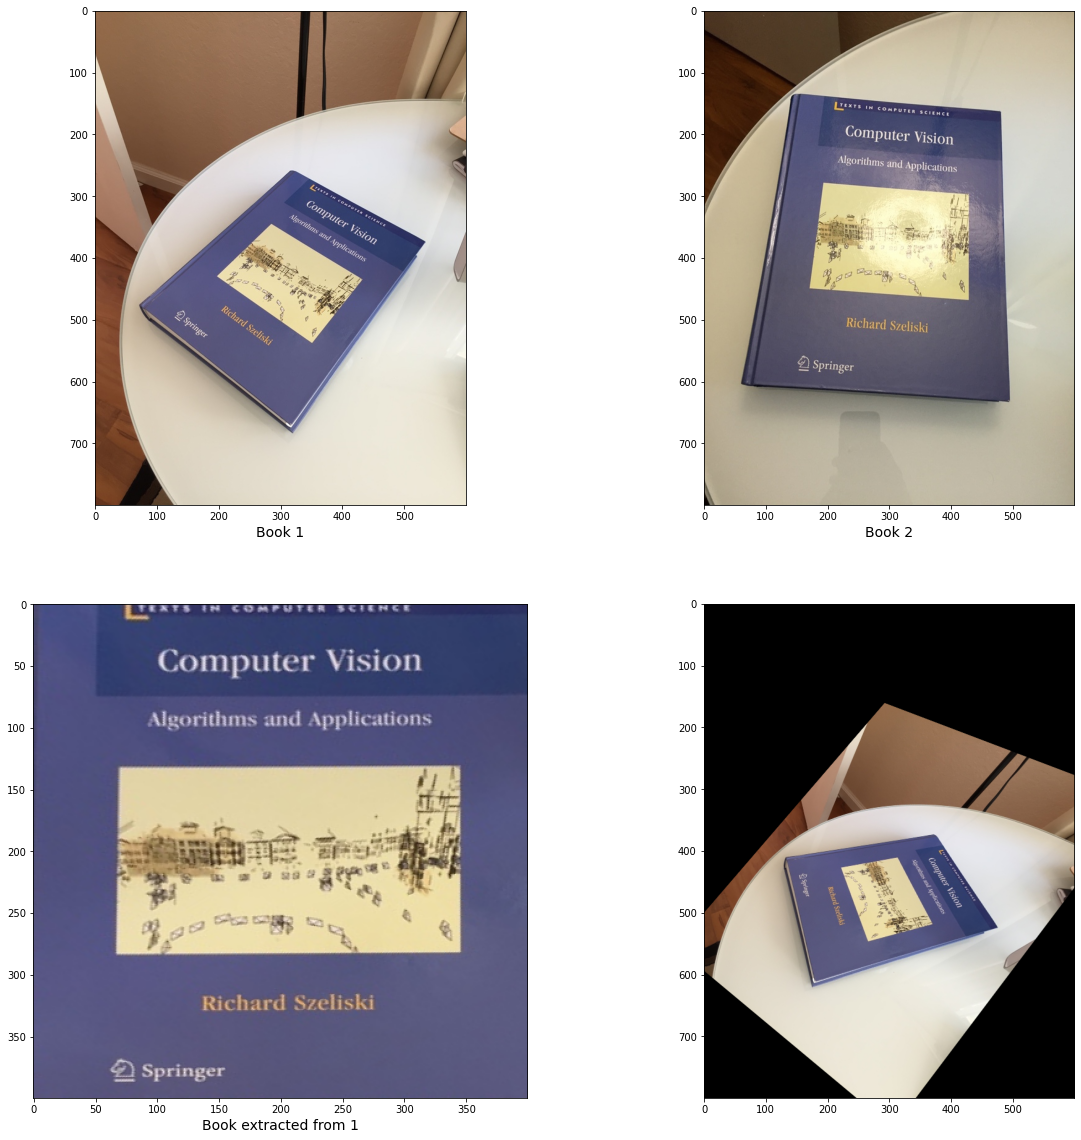

In [4]:
book1 = cv2.imread('/content/drive/My Drive/Day4 Material/book1.jpg')
book2 = cv2.imread('/content/drive/My Drive/Day4 Material/book2.jpg')
book1 = cv2.cvtColor(book1, cv2.COLOR_BGR2RGB)
book2 = cv2.cvtColor(book2, cv2.COLOR_BGR2RGB)
# print(book1.shape)
# print(book2.shape)
# cv2_imshow(np.hstack([book1, book2]))

#Homography 

# pts1 = np.load('/content/drive/My Drive/Day4 Material/Points.npy')
size = 400
pts1 = np.float32([[318., 263.], [524., 376.], [310., 660.], [ 87., 479.]])
pts2 = np.float32([ [0, 0], [size -1, 0], [size -1, size -1], [0, size-1]])
transform_matrix = cv2.getPerspectiveTransform(pts1, pts2)
book1_homo = cv2.warpPerspective(book1, transform_matrix, (size, size))

# cv2_imshow(book1_homo)
fig, ((ax1,ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,20), constrained_layout=False)
ax1.imshow(book1)
ax1.set_xlabel("Book 1", fontsize=14)
ax2.imshow(book2)
ax2.set_xlabel("Book 2", fontsize=14)
ax3.imshow(book1_homo)
ax3.set_xlabel("Book extracted from 1", fontsize = 14)


# pts_src = np.array([[141, 131], [480, 159], [493, 630],[64, 601]], dtype=float)
# pts_dst = np.array([[318, 256],[534, 372],[316, 670],[73, 473]], dtype=float)

pts_src = np.float32([[141, 131], [480, 159], [493, 630],[64, 601]])
pts_dst = np.float32([[318, 256],[534, 372],[316, 670],[73, 473]])

transform_matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
aligned = cv2.warpPerspective(book1, transform_matrix, (book1.shape[1], book1.shape[0]))
ax4.imshow(aligned)

Task3) You can take tsukuba_l and tsukuba_r images from the drive link and use 

cv2.StereoBM_create(numDisparities=16, blockSize=15) to get disparity map

After getting the disparity map try to remove objects from the image whose disparity is  less  than a  particular threshold say 120.


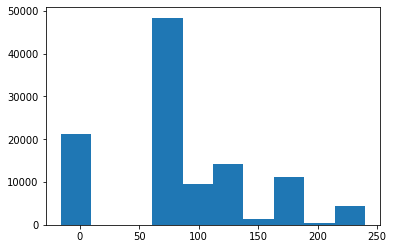

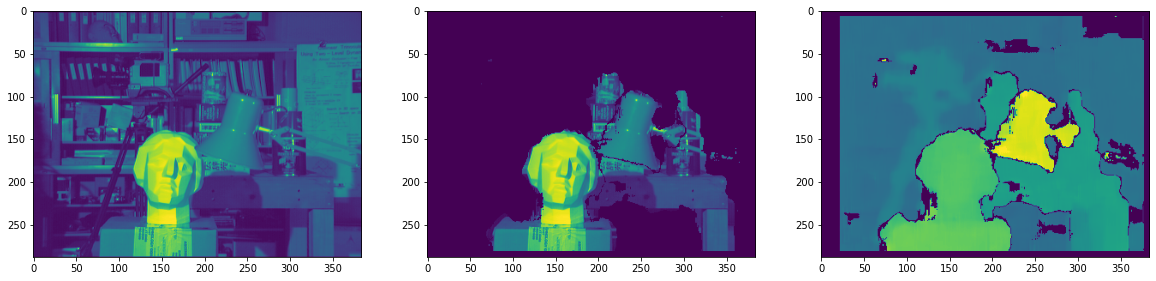

In [5]:
left = cv2.imread('/content/drive/My Drive/Day4 Material/tsukuba_l.png', cv2.IMREAD_GRAYSCALE)
right = cv2.imread('/content/drive/My Drive/Day4 Material/tsukuba_r.png', cv2.IMREAD_GRAYSCALE)
# cv2_imshow(np.hstack([left,right]))

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left, right)
plt.hist(disparity.ravel())

def clean_disparity(image, disparity, thresh):
  img = np.copy(image)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if disparity[i,j] <= thresh:
        img[i,j] = 0
  return img

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,20), constrained_layout=False)
ax1.imshow(left)
ax2.imshow(clean_disparity(left,disparity,120))
ax3.imshow(disparity)

#NOTE : Black and white looks better in green :)

#Compute Disparity by hand using SDD

In [0]:
#filter size 3

left = cv2.imread('/content/drive/My Drive/Day4 Material/view0.png', cv2.IMREAD_GRAYSCALE)
h,w = left.shape
l = np.zeros((h+2, w + 2))
l[1:-1,1:-1] = left
left = l
right = cv2.imread('/content/drive/My Drive/Day4 Material/view1.png', cv2.IMREAD_GRAYSCALE)
l = np.zeros((h+2, w + 2))
l[1:-1,1:-1] = right
right = l
# cv2_imshow(np.hstack([left,right]))

disp = np.zeros((h,w))

def cost_func(a,b):
  return ((a-b)**2).sum()

for i in range(h):
  for j in range(w):
    m, idx = 100000000, j
    for k in range(j,w):
      c = (( left[i+1,k+1].astype('int') - right[i+1,k+1].astype('int') )**2).sum()
      if c < m:
        m = c
        idx = k
    disp[i,j] = abs(idx - j)

###Result : We can make out the pins and the ball upon close obseravtion.

3 x 3 matrix is used.

The code not being vectorized is very slow. 

Conclusion: This prototype verifies the method, but it is very unrefined and slow. Implementation has to be vectorized and filter must be choosen well.

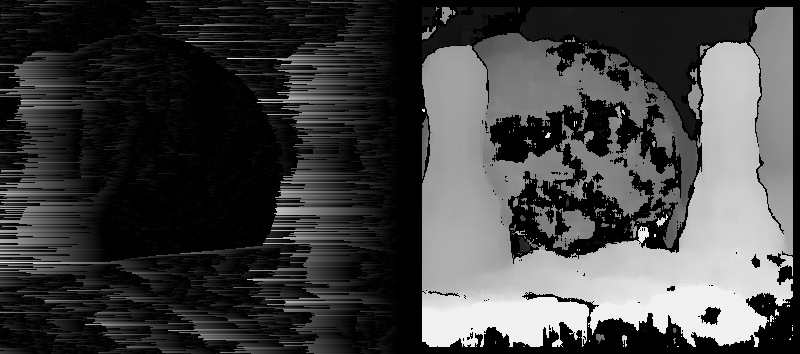

In [13]:
copy = np.copy(disp)
copy = ((copy - copy.min())/copy.max() * 255).astype('uint8')

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(left[1:-1,1:-1].astype('uint8'), right[1:-1,1:-1].astype('uint8'))

cv2_imshow(np.hstack([copy, disparity]))